In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

### Def functions

In [56]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1
    return d_avg

In [57]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [58]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [59]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    st = 0
    end =1
    if color_orient == 1:
        st = 1
        end =2
    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim,start=st, end=end)==color_orient)
        tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

In [60]:
## Permutation test
def permutation_test(mean_select,mean_null):
    radius = mean_select[:,0]
    angle =  mean_select[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_dir_vector = np.sqrt(X**2+Y**2)
    radius = mean_null[:,0]
    angle =  mean_null[:,1]
    X = (np.array(radius) * np.cos(angle))
    Y = (np.array(radius) * np.sin(angle))
    ampl_null_vector = np.sqrt(X**2+Y**2)
    diff=[]
    for i in range(len(ampl_dir_vector)):
        # rotate vecto to compare all values with the null vector
        shift = np.concatenate([ampl_dir_vector[i:],ampl_dir_vector[:i]])
        diff.append(shift-ampl_null_vector)
    diff=np.concatenate(diff)
    p_value = np.sum(diff<0)/len(diff)
    return p_value

In [61]:
def get_null_vector_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

    for n_it in range(n_iterations):
        all_sample1 = []
        
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
       
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [62]:
def select_rand_trials_from_samples(trials_fr,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr = np.random.choice(trials_fr[i_num], size=min_n_trials[i_num], replace=True, p=None)
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

### Read paths

In [63]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [64]:
paths_bhv[31:]

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-30_10-36-53_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-06_10-38-57_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-09_11-13-27_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-10_10-41-43_Riesling_e1_r1_bhv.h5']

### Define parameters

In [65]:
orient = 0 
color = 1
n_iterations = 1000
win=100
step=1
#color_orient = color
i_neuron = 3

In [79]:
n_bhv=paths_bhv[34]
n_sp = paths_sp[34]
print(n_sp)
s_path = os.path.normpath(n_sp).split(os.sep)
date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)
print(data.clustersgroup)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-10-10_10-41-43_Riesling_lip_e1_r1_sp.h5
['mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'mua' 'good' 'good' 'mua'
 'good']


In [76]:
# Neurons I checked
# path 0:  2022-11-22_10-59-03 i_neuron:3 -> selective (not a lot) to o1,no shift
# path 0:  2022-11-22_10-59-03 i_neuron:4 -> selective to o3, orientation shift, not a lot of trials
# path 2:  2022-11-30_10-42-03 i_neuron:2 -> a little bit of shift in orientation (but selectivity is not significant)
# path 4:  2022-12-01_12-01-59 i_neuron:5 -> no enough trials
# path 5:  2022-12-02_11-01-23 i_neuron:4 -> selective to O2 but no shift
# path 6:  2022-12-05_10-51-52 i_neuron:8 -> no spikes
# path 6:  2022-12-05_10-51-52 i_neuron:16 -> selective to O3 (during O1), shift toward
# path 9:  2022-12-14_10-50-49 i_neuron:0 -> no selectivity
# path 10: 2022-12-16_10-30-59 i_neuron:3 -> no selectivity
# path 10: 2022-12-16_10-30-59 i_neuron:4 -> no selectivity
# path 14: 2023-01-26_10-45-42 i_neuron:1 -> no selectivity
# path 14: 2023-01-26_10-45-42 i_neuron:8 -> no selectivity
# path 16: 2023-02-09_10-42-54 i_neuron:2 -> selective to O5 -------
# path 17: 2023-02-24_10-43-44 i_neuron:0 -> not significant
# path 27: 2023-03-17_10-11-51 i_neuron:0 -> no selectivity
# path 27: 2023-03-17_10-11-51 i_neuron:1 -> no selectivity
# path 27: 2023-03-17_10-11-51 i_neuron:2 -> selective to O6, no shift
# path 27: 2023-03-17_10-11-51 i_neuron:3 -> no selectivity
# path 27: 2023-03-17_10-11-51 i_neuron:5 -> no selectivity
# path 27: 2023-03-17_10-11-51 i_neuron:8 -> no selectivity
# path 28: 2023-03-20_10-39-08 i_neuron:3 -> selective to O7, no shift
# path 28: 2023-03-20_10-39-08 i_neuron:7 -> no selectivity
# path 28: 2023-03-20_10-39-08 i_neuron:8 -> no selectivity
# path 28: 2023-03-20_10-39-08 i_neuron:10 -> selective to O7, no shift

### Check number of trials (correct and incorrect)

In [80]:
# correct and incorrect trials
trial_idx = np.where(data.block == 1)[0]

if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task_cor_inc = def_task.create_task_frame(
    condition=bhv.condition[trial_idx],
    test_stimuli=bhv.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task_cor_inc = task_cor_inc[task_cor_inc['in_out']=='in']

In [69]:
task_one_neuron = task_cor_inc[task_cor_inc['i_neuron']==i_neuron]
n_trials_sample = task_one_neuron[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_one_neuron[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

        i_neuron
sample          
o1_c1        220
o1_c5        210
o5_c1        224
o5_c5        230


KeyError: 'o0_c0'

### Select correct trials inside the rf and define task df

In [83]:
task_corr_in, idx_tr_corr_in = get_task_variables(data,bhv,in_out='in')

In [84]:
task_corr_in.head()

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,9,o1_c1,in,4,6
1,0,13,o1_c1,in,1,1
2,0,24,o1_c1,in,4,6
3,0,28,o1_c1,in,4,4
4,0,35,o1_c1,in,1,7


In [99]:
test_stimuli

array([[11., nan, nan, nan],
       [65., 11., 14., 51.],
       [31., 55., 31., 15.],
       ...,
       [55., 74., 32., 18.],
       [15., nan, nan, nan],
       [53., 15., 68., 51.]])

In [105]:
np.sum(code_numbers[:,10:]==33)

0

In [85]:
# Select data for the relevant trials
test_stimuli = bhv.test_stimuli[idx_tr_corr_in]
code_numbers = data.code_numbers[idx_tr_corr_in]
code_samples = data.code_samples[idx_tr_corr_in]
sp_samples = data.sp_samples[idx_tr_corr_in,i_neuron]

In [86]:
task_one_neuron=task_corr_in[task_corr_in['i_neuron']==i_neuron]
task_trials = task_one_neuron['trial_idx'].values
# select trials with at least one spike
trial_idx = task_trials[np.nansum(sp_samples[task_trials],axis=1)>0]
task_fr = task_one_neuron[np.in1d(task_one_neuron['trial_idx'] , trial_idx)]

In [87]:
n_trials_sample = task_fr[['i_neuron','sample']].groupby(['sample']).count()
print(n_trials_sample)
sorted_samples = task_fr[['trial_idx','sample']].sort_values('trial_idx').reset_index(drop=True)['sample'].values
samples_dict = {'current':[],'previous':[]}
prev_sampl = sorted_samples[0]
for i_sample in sorted_samples[1:]:
    samples_dict['current'].append(i_sample)
    samples_dict['previous'].append(prev_sampl)
    prev_sampl = i_sample
samples_dict = pd.DataFrame(samples_dict)
curr_prev_sample = samples_dict.reset_index().groupby(['current','previous']).count().reset_index()
df = curr_prev_sample.pivot(index="previous", columns="current", values="index")
df['o0_c0'] = df['o0_c0']/n_trials_sample.loc['o0_c0'].values[0]
df['o1_c1'] = df['o1_c1']/n_trials_sample.loc['o1_c1'].values[0]
df['o1_c5'] = df['o1_c5']/n_trials_sample.loc['o1_c5'].values[0]
df['o5_c1'] = df['o5_c1']/n_trials_sample.loc['o5_c1'].values[0]
df['o5_c5'] = df['o5_c5']/n_trials_sample.loc['o5_c5'].values[0]
sns.heatmap(df)
df

        i_neuron
sample          
o1_c1         96
o1_c5         82
o5_c1         59
o5_c5         66


KeyError: 'o0_c0'

In [88]:
print(df['o1_c1'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c1'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

56
40


In [89]:
print(df['o1_c5'].loc['o1_c1']+df['o1_c1'].loc['o1_c5'])
print(df['o1_c5'].loc['o5_c1']+df['o1_c1'].loc['o5_c5'])

47
34


/tmp/ipykernel_139461/1990791403.py:3: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


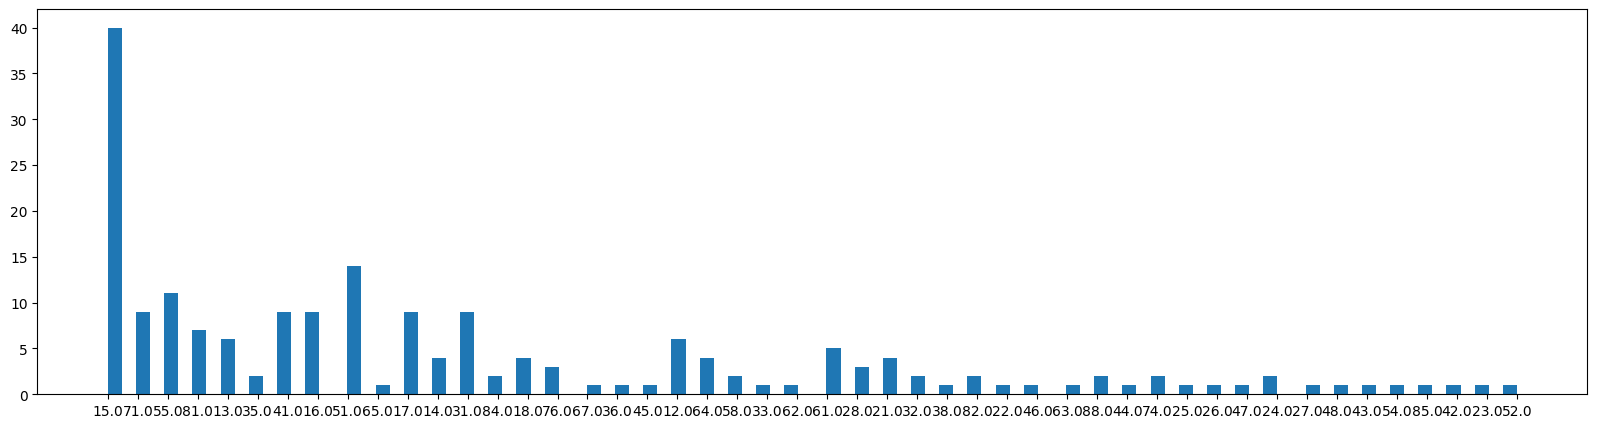

In [90]:
task_sample = task_fr[task_fr['sample']=='o1_c1']
test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
test_stimuli_samp = test_stimuli_samp.astype(str)
concat = np.concatenate(test_stimuli_samp)
concat = concat[np.where(np.logical_or(concat == 'nan',concat=='11.0'),False,True)]
fif,ax = plt.subplots(figsize=(20,5))
c=ax.hist(concat,bins=100)

<AxesSubplot: >

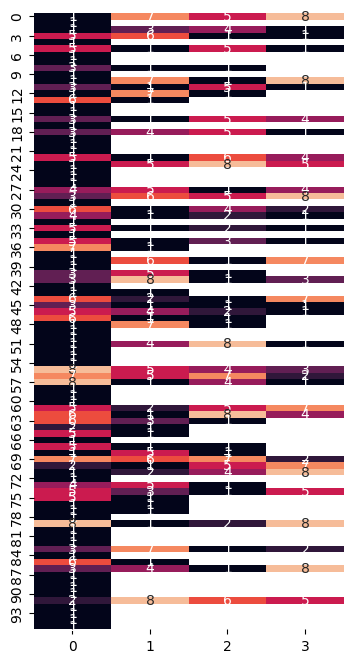

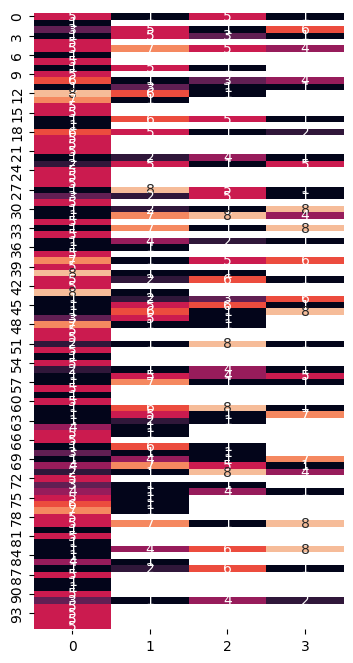

In [91]:
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'1',start=0, end=1)==orient,'o1','nan')
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'2',start=0, end=1)==orient,'o2',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'3',start=0, end=1)==orient,'o3',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'4',start=0, end=1)==orient,'o4',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'5',start=0, end=1)==orient,'o5',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'6',start=0, end=1)==orient,'o6',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'7',start=0, end=1)==orient,'o7',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(test_stimuli_samp,'8',start=0, end=1)==orient,'o8',test_stimuli_o1)
mask = np.where(test_stimuli_o1=='nan',True,False)
test_stimuli_o = pd.DataFrame(test_stimuli_o1).replace(['o1','o2','o3','o4','o5','o6','o7','o8','nan'],[1,2,3,4,5,6,7,8,np.nan])
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_o,mask=mask,vmax = 9,annot=True,cbar=False)

test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'1',start=1, end=2)==color,'c1','nan')
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'2',start=1, end=2)==color,'c2',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'3',start=1, end=2)==color,'c3',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'4',start=1, end=2)==color,'c4',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'5',start=1, end=2)==color,'c5',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'6',start=1, end=2)==color,'c6',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'7',start=1, end=2)==color,'c7',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(test_stimuli_samp,'8',start=1, end=2)==color,'c8',test_stimuli_c1)
mask = np.where(test_stimuli_c1=='nan',True,False)
test_stimuli_c = pd.DataFrame(test_stimuli_c1).replace(['c1','c2','c3','c4','c5','c6','c7','c8','nan'],[1,2,3,4,5,6,7,8,np.nan])
fx = plt.subplots(figsize=(4,8))
sns.heatmap(test_stimuli_c,mask=mask,vmax = 9,annot=True,cbar=False)

/tmp/ipykernel_139461/1640235395.py:3: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


<AxesSubplot: xlabel='0', ylabel='Count'>

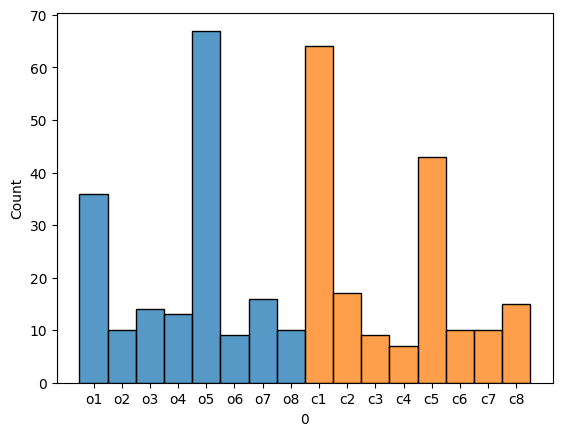

In [92]:
task_sample = task_fr[task_fr['sample']=='o1_c5']
test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
test_stimuli_samp = test_stimuli_samp.astype(str)
concat = np.concatenate(test_stimuli_samp)
concat = concat[np.where(np.logical_or(concat == 'nan',concat=='15.0'),False,True)]

test_stimuli_o1 = np.where(np.char.find(concat,'1',start=0, end=1)==orient,'o1','nan')
test_stimuli_o1 = np.where(np.char.find(concat,'2',start=0, end=1)==orient,'o2',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'3',start=0, end=1)==orient,'o3',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'4',start=0, end=1)==orient,'o4',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'5',start=0, end=1)==orient,'o5',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'6',start=0, end=1)==orient,'o6',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'7',start=0, end=1)==orient,'o7',test_stimuli_o1)
test_stimuli_o1 = np.where(np.char.find(concat,'8',start=0, end=1)==orient,'o8',test_stimuli_o1)

test_stimuli_c1 = np.where(np.char.find(concat,'1',start=1, end=2)==color,'c1','nan')
test_stimuli_c1 = np.where(np.char.find(concat,'2',start=1, end=2)==color,'c2',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'3',start=1, end=2)==color,'c3',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'4',start=1, end=2)==color,'c4',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'5',start=1, end=2)==color,'c5',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'6',start=1, end=2)==color,'c6',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'7',start=1, end=2)==color,'c7',test_stimuli_c1)
test_stimuli_c1 = np.where(np.char.find(concat,'8',start=1, end=2)==color,'c8',test_stimuli_c1)
mask = np.where(test_stimuli_o1=='nan',False,True)
f,ax = plt.subplots()
sns.histplot(pd.DataFrame(test_stimuli_o1[mask]).sort_values(0),x=0)
mask = np.where(test_stimuli_c1=='nan',False,True)
sns.histplot(pd.DataFrame(test_stimuli_c1[mask]).sort_values(0),x=0)


o1_c1
o1c1 34
o5c5 11
o1c5 40
o5c1 14
o5_c5
o1c1 54
o5c5 6
o1c5 7
o5c1 6


/tmp/ipykernel_139461/1331398040.py:7: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


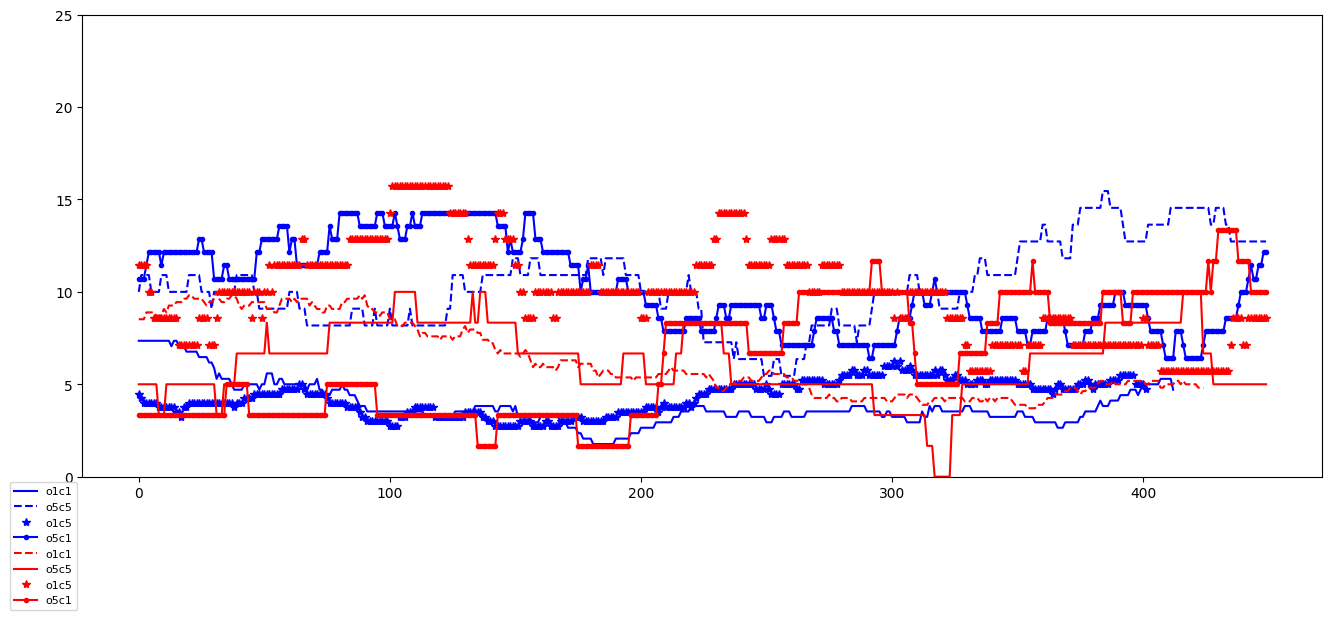

In [93]:
fig,ax = plt.subplots(figsize = (16,6))
for sample in ['o1_c1','o5_c5']:
    task_sample = task_fr[task_fr['sample']==sample]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli_samp.astype(str)

    test_stimuli_o1c1 = np.where(np.char.find(test_stimuli_samp,'11')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    test_stimuli_o5c5 = np.where(np.char.find(test_stimuli_samp,'55')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c5 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    test_stimuli_o1c5 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c5 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
    
    test_stimuli_o5c1 = np.where(np.char.find(test_stimuli_samp,'51')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    print(sample)
    sp_tests_o1c1_avg = sp_tests_o1c1.mean(axis=0)
    print('o1c1 %d'%sp_tests_o1c1.shape[0])
    sp_tests_o5c5_avg = sp_tests_o5c5.mean(axis=0)
    print('o5c5 %d'%sp_tests_o5c5.shape[0])
    sp_tests_o1c5_avg = sp_tests_o1c5.mean(axis=0)
    print('o1c5 %d'%sp_tests_o1c5.shape[0])
    sp_tests_o5c1_avg = sp_tests_o5c1.mean(axis=0)
    print('o5c1 %d'%sp_tests_o5c1.shape[0])
    sp_tests_o1c1_avg = moving_average(data=sp_tests_o1c1_avg,win=win,step=1)[:450]*1000
    sp_tests_o5c5_avg = moving_average(data=sp_tests_o5c5_avg,win=win,step=1)[:450]*1000
    sp_tests_o1c5_avg = moving_average(data=sp_tests_o1c5_avg,win=win,step=1)[:450]*1000
    sp_tests_o5c1_avg = moving_average(data=sp_tests_o5c1_avg,win=win,step=1)[:450]*1000

    style1 = 'b-'
    style2 = 'b--'
    style3 = 'b*'
    style4 = 'b.-'
    if sample == 'o5_c5':
        style1 = 'r--'
        style2 = 'r-'
        style3 = 'r*'
        style4 = 'r.-'
    ax.plot(sp_tests_o1c1_avg,style1,label='o1c1')
    ax.plot(sp_tests_o5c5_avg,style2,label='o5c5')
    ax.plot(sp_tests_o1c5_avg,style3,label='o1c5')
    ax.plot(sp_tests_o5c1_avg,style4,label='o5c1')
    ax.set_ylim(0,25)
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_139461/2763307770.py:7: RuntimeWarning: invalid value encountered in cast
  test_stimuli_samp = test_stimuli_samp.astype(str)


o1_c5
o1c1 9
o5c5 10
o1c5 38
o5c1 49
o5_c1
o1c1 7
o5c5 45
o1c5 9
o5c1 10


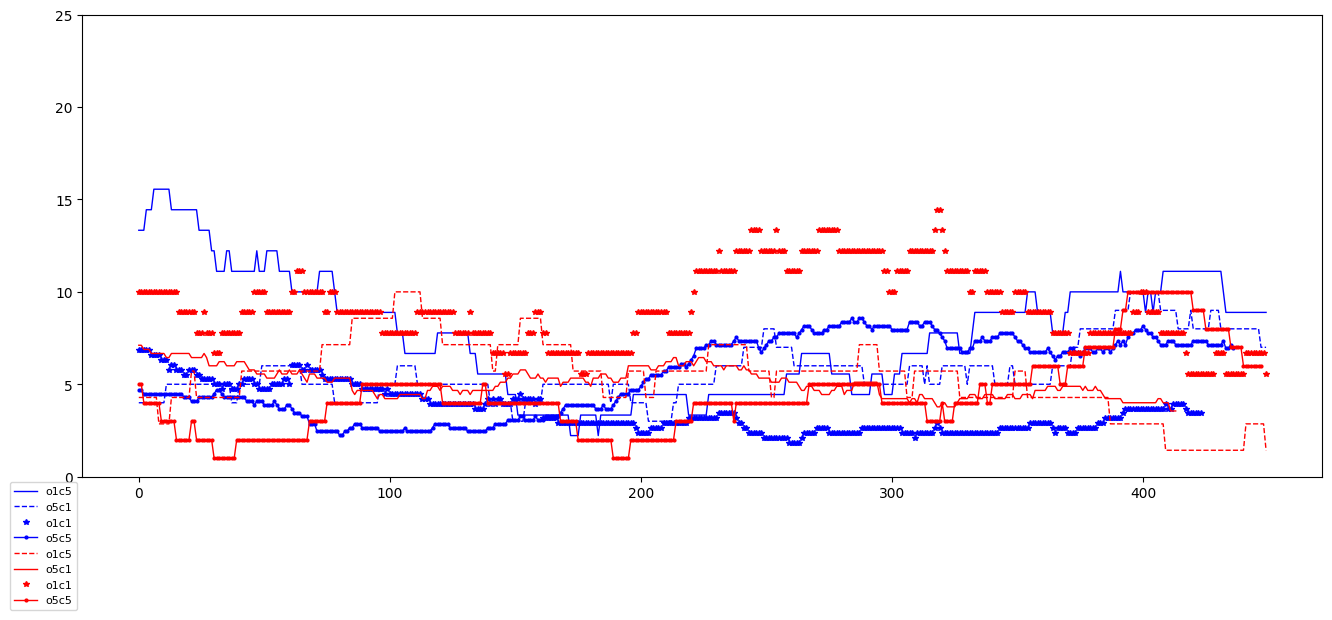

In [94]:
fig,ax = plt.subplots(figsize = (16,6))
for sample in ['o1_c5','o5_c1']:
    task_sample = task_fr[task_fr['sample']==sample]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    test_stimuli_samp = test_stimuli_samp.astype(str)

    test_stimuli_o1c1 = np.where(np.char.find(test_stimuli_samp,'11')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    test_stimuli_o5c5 = np.where(np.char.find(test_stimuli_samp,'55')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c5 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    test_stimuli_o1c5 = np.where(np.char.find(test_stimuli_samp,'15')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o1c5)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o1c5 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
    
    test_stimuli_o5c1 = np.where(np.char.find(test_stimuli_samp,'51')==0,True,False)
    i_trial, i_test = np.where(test_stimuli_o5c1)
    tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
    sp_stim = sp_samples_samp[i_trial]
    sp_tests_o5c1 = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]

    print(sample)
    sp_tests_o1c1_avg = sp_tests_o1c1.mean(axis=0)
    print('o1c1 %d'%sp_tests_o1c1.shape[0])
    sp_tests_o5c5_avg = sp_tests_o5c5.mean(axis=0)
    print('o5c5 %d'%sp_tests_o5c5.shape[0])
    sp_tests_o1c5_avg = sp_tests_o1c5.mean(axis=0)
    print('o1c5 %d'%sp_tests_o1c5.shape[0])
    sp_tests_o5c1_avg = sp_tests_o5c1.mean(axis=0)
    print('o5c1 %d'%sp_tests_o5c1.shape[0])
    sp_tests_o1c1_avg = moving_average(data=sp_tests_o1c1_avg,win=win,step=1)[:450]*1000
    sp_tests_o5c5_avg = moving_average(data=sp_tests_o5c5_avg,win=win,step=1)[:450]*1000
    sp_tests_o1c5_avg = moving_average(data=sp_tests_o1c5_avg,win=win,step=1)[:450]*1000
    sp_tests_o5c1_avg = moving_average(data=sp_tests_o5c1_avg,win=win,step=1)[:450]*1000

    style1 = 'b-'
    style2 = 'b--'
    style3 = 'b*'
    style4 = 'b.-'
    if sample == 'o5_c1':
        style1 = 'r--'
        style2 = 'r-'
        style3 = 'r*'
        style4 = 'r.-'
    ax.plot(sp_tests_o1c1_avg,style1,label='o1c5',linewidth=1,markersize=4)
    ax.plot(sp_tests_o5c5_avg,style2,label='o5c1',linewidth=1,markersize=4)
    ax.plot(sp_tests_o1c5_avg,style3,label='o1c1',linewidth=1,markersize=4)
    ax.plot(sp_tests_o5c1_avg,style4,label='o5c5',linewidth=1,markersize=4)
    ax.set_ylim(0,25)
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by samples

In [95]:
len_s_on=450
len_d=450
len_t = 450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_sample_on = np.zeros((4,len_s_on))
all_sp_delay = np.zeros((4,len_d))
all_sp_test1 = np.zeros((4,len_t))
all_sp_test2=np.zeros((4,len_t))
all_sp_test3=np.zeros((4,len_t))
all_sp_test4=np.zeros((4,len_t))
all_sp_test5=np.zeros((4,len_t))

for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task_fr[task_fr['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    sp_sample_on = sp_sample_on.mean(axis=0)
    all_sp_sample_on[i] = moving_average(data=sp_sample_on,win=win,step=1)[:len_s_on]*1000
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d+win]
    sp_delay = sp_delay.mean(axis=0)
    all_sp_delay[i] = moving_average(data=sp_delay,win=win,step=1)[:len_d]*1000
    # test 1
    idx = np.where(~np.isnan(code_samples_samp[:,6]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test1[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 2
    idx = np.where(~np.isnan(code_samples_samp[:,8]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test2[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 3
    idx = np.where(~np.isnan(code_samples_samp[:,10]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test3[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 4
    idx = np.where(~np.isnan(code_samples_samp[:,12]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test4[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000
    # test 5
    idx = np.where(~np.isnan(code_samples_samp[:,14]))[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t+win]
    idx=np.where(~np.isnan(np.sum(sp_test,axis=1)))[0]
    sp_test = sp_test[idx].mean(axis=0)
    all_sp_test5[i] = moving_average(data=sp_test,win=win,step=1)[:len_t]*1000


/tmp/ipykernel_139461/1205394117.py:56: RuntimeWarning: Mean of empty slice.
  sp_test = sp_test[idx].mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


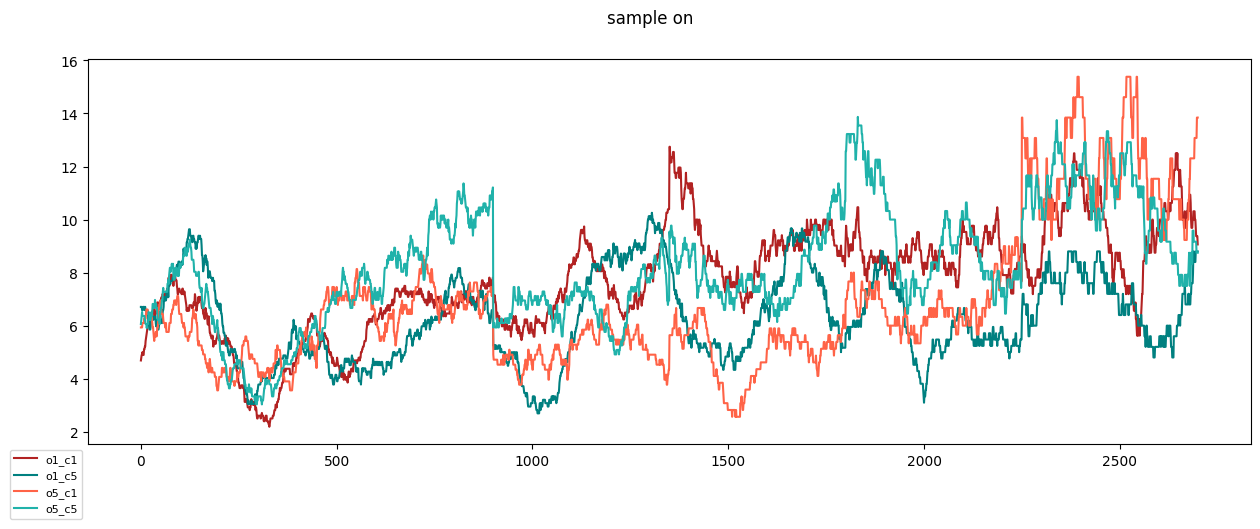

In [96]:
all_sp_epochs = np.concatenate([all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5],axis=1)
fig,ax = plt.subplots(figsize = (15,5))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    ax.plot(all_sp_epochs[i],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by feature (color 1, color 5, orientation 1, orientation 5)

In [98]:
win=100
all_sp_test1 = np.zeros((4,len_t+win))
all_sp_test2 = np.zeros((4,len_t+win))
all_sp_test3 = np.zeros((4,len_t+win))
all_sp_test4 = np.zeros((4,len_t+win))
all_sp_test5 = np.zeros((4,len_t+win))
all_sp_delay = np.zeros((4,len_t+win))
all_sp_sample_on = np.zeros((4,len_t+win))

# task_one_neuron=task_corr_in[task_corr_in['i_neuron']==i_neuron]
# task_trials = task_one_neuron['trial_idx'].values
# trial_idx = task_trials[np.nansum(data.sp_samples[idx_tr_corr_in[task_trials],i_neuron],axis=1)>0]
# task_fr = task_one_neuron[np.in1d(task_one_neuron['trial_idx'] , trial_idx)]

# all_feature_t5_avg=[]
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task_fr[task_fr['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    # sample on
    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
    # delay
    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)
    # test 1
    idx = np.where(test_stimuli_samp[:,0]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t+win]
    all_sp_test1[i] = sp_test.mean(axis=0)
    # test 2 
    idx = np.where(test_stimuli_samp[:,1]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t+win]
    all_sp_test2[i] = sp_test.mean(axis=0)
    # test 3
    idx = np.where(test_stimuli_samp[:,2]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t+win]    
    all_sp_test3[i] = sp_test.mean(axis=0)
    # test 4
    idx = np.where(test_stimuli_samp[:,3]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t+win]
    all_sp_test4[i] = sp_test.mean(axis=0)
    # test 5
    idx = np.where(test_stimuli_samp[:,4]!='nan')[0]
    sp_test = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t+win]
    all_sp_test5[i] = sp_test.mean(axis=0)

all_sp_epochs_feture = [all_sp_sample_on,all_sp_delay,all_sp_test1,all_sp_test2,all_sp_test3,all_sp_test4,all_sp_test5]

IndexError: index 5 is out of bounds for axis 1 with size 5

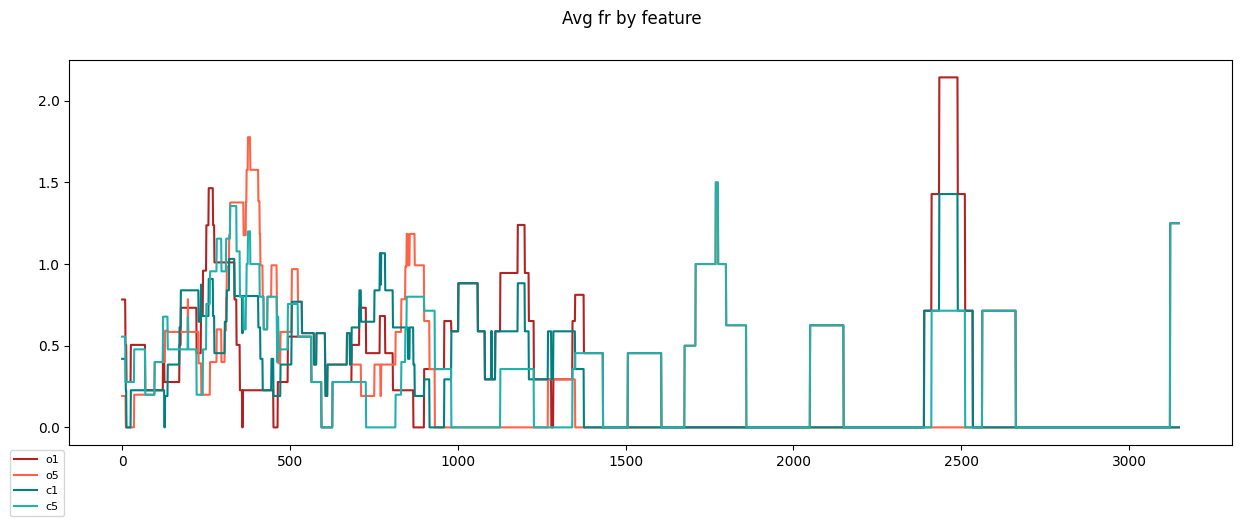

In [ ]:
o1_avg_feature=[]
o5_avg_feature=[]
c1_avg_feature=[]
c5_avg_feature=[]
fig,ax = plt.subplots(figsize=(15,5))
for i,all_sp in enumerate(all_sp_epochs_feture):
    o1 = np.mean([all_sp[0],all_sp[1]],axis=0)
    o5 = np.mean([all_sp[2],all_sp[3]],axis=0)
    c1 = np.mean([all_sp[0],all_sp[2]],axis=0)
    c5 = np.mean([all_sp[1],all_sp[3]],axis=0)
    o1_avg_feature.append(moving_average(data=o1,win=win,step=1)[:450]*1000)
    o5_avg_feature.append(moving_average(data=o5,win=win,step=1)[:450]*1000)
    c1_avg_feature.append(moving_average(data=c1,win=win,step=1)[:450]*1000)
    c5_avg_feature.append(moving_average(data=c5,win=win,step=1)[:450]*1000)
o1_avg_feature=np.concatenate(o1_avg_feature)
o5_avg_feature=np.concatenate(o5_avg_feature)
c1_avg_feature=np.concatenate(c1_avg_feature)
c5_avg_feature=np.concatenate(c5_avg_feature)
ax.plot(o1_avg_feature,label='o1',color=task_constants.PALETTE_B1["o1_c1"])
ax.plot(o5_avg_feature,label='o5',color=task_constants.PALETTE_B1["o5_c1"])
ax.plot(c1_avg_feature,label='c1',color=task_constants.PALETTE_B1["o1_c5"])
ax.plot(c5_avg_feature,label='c5',color=task_constants.PALETTE_B1["o5_c5"])
fig.suptitle('Avg fr by feature')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Average trials by test number and feature

In [ ]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature_tests = {"o1_c1":{"color":{},"orientation":{}},"o1_c5":{"color":{},"orientation":{}},"o5_c1":{"color":{},"orientation":{}},"o5_c5":{"color":{},"orientation":{}}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    color_tests = []
    orient_tests = []
    task_sample = task_fr[task_fr['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    
    for n_t in range(test_stimuli_samp.shape[1]):
        n_test = np.full(test_stimuli_samp.shape,np.nan)
        n_test[:,n_t] = test_stimuli_samp[:,n_t]
        color_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=color,stim_num=stim_num)
        orient_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=orient,stim_num=stim_num)
        all_sample_feature_tests[sample]["color"][str(n_t)]= color_tests
        all_sample_feature_tests[sample]["orientation"][str(n_t)]= orient_tests

/tmp/ipykernel_139461/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)
/tmp/ipykernel_139461/4267467123.py:22: RuntimeWarning: invalid value encountered in cast
  color_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=color,stim_num=stim_num)
/tmp/ipykernel_139461/4267467123.py:23: RuntimeWarning: invalid value encountered in cast
  orient_tests=get_sp_feature(sp_samples_samp,n_test.astype(str),code_samples_samp,color_orient=orient,stim_num=stim_num)


/tmp/ipykernel_139461/2425560791.py:6: RuntimeWarning: Mean of empty slice.
  tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


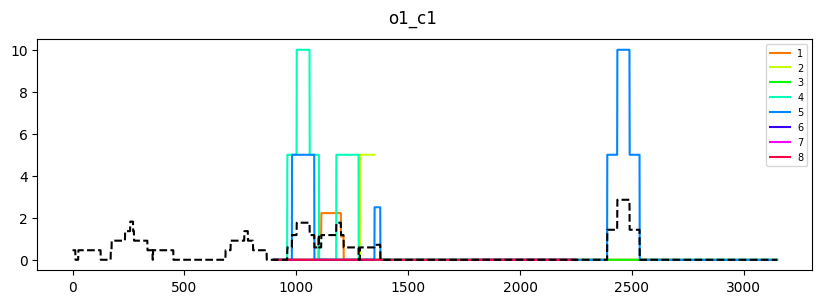

In [ ]:
palette = plt.get_cmap('hsv',64)
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    for i in range(8):
        tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0)
        tests = moving_average(data=tests,win=win,step=1)*1000
        o1_c1_orient_test.append(tests[:450])   
    o1_c1_orient.append(o1_c1_orient_test)

palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')
plt.legend( prop={'size': 7})

Text(0.5, 0.98, 'o1_c1')

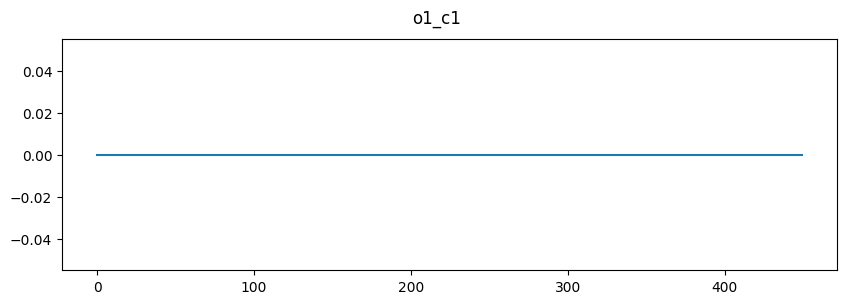

In [ ]:
o1_c1_orient = []
for i_test in range(5):
    o1_c1_orient_test = []
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][5]
    for i_test in tests:
        i_test = moving_average(data=i_test,win=win,step=1)*1000
        o1_c1_orient_test.append(i_test[:450])   
    o1_c1_orient.append(o1_c1_orient_test)
palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i_tr in o1_c1_orient[0]:
    ax.plot(i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[1]:
    ax.plot(np.arange(450,450*2),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[2]:
    ax.plot(np.arange(450*2,450*3),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[3]:
    ax.plot(np.arange(450*3,450*4),i_tr,label=stim_num[i])
for i_tr in o1_c1_orient[4]:
    ax.plot(np.arange(450*4,450*5),i_tr,label=stim_num[i])
#ax.plot(all_sp_epochs[0],'k--')
fig.suptitle('o1_c1')


Text(0.5, 0.98, 'o1_c1')

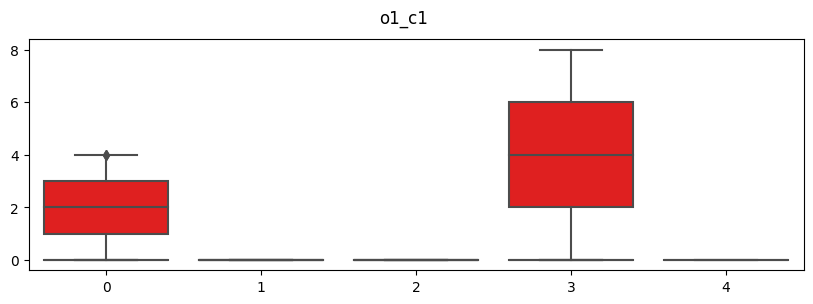

In [ ]:
o1_c1_orient0 = []
o1_c1_orient5 = []
for i_test in range(5):
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][0]
    o1_c1_orient0.append(tests[:,100:350].mean(axis=1)*1000)   
    tests=all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][4]
    o1_c1_orient5.append(tests[:,100:350].mean(axis=1)*1000)   

palette = plt.get_cmap('hsv',64)
#all_o1_tests = np.concatenate([o1_c1_orient[0],o1_c1_orient[1],o1_c1_orient[2],o1_c1_orient[3],o1_c1_orient[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
sns.boxplot(o1_c1_orient0,color='b')
sns.boxplot(o1_c1_orient5,color='r')
fig.suptitle('o1_c1')

In [ ]:
o1_tests = []
o5_tests = []
c1_tests = []
c5_tests = []
for i_test in range(5):
    o1,o5,c1,c5 = [],[],[],[]
    for i in range(8):
        o1_avg = np.array([all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o1_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o1_avg = np.mean(o1_avg,axis=0)
        o1_avg = moving_average(data=o1_avg,win=win,step=1)*1000
        o1.append(o1_avg[:450])
        # o5.append()
        o5_avg = np.array([all_sample_feature_tests["o5_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
        o5_avg = np.mean(o5_avg,axis=0)
        o5_avg = moving_average(data=o5_avg,win=win,step=1)*1000
        o5.append(o5_avg[:450])
        # c1.append()
        c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
        c1_avg = np.mean(c1_avg,axis=0)
        c1_avg = moving_average(data=c1_avg,win=win,step=1)*1000
        c1.append(c1_avg[:450])
        # c5.append()
        c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
        c5_avg = np.mean(c5_avg,axis=0)
        c5_avg = moving_average(data=c5_avg,win=win,step=1)*1000
        c5.append(c5_avg[:450])
    o1_tests.append(o1)
    o5_tests.append(o5)
    c1_tests.append(c1)
    c5_tests.append(c5)

/tmp/ipykernel_139461/115818640.py:8: RuntimeWarning: Mean of empty slice.
  o1_avg = np.array([all_sample_feature_tests["o1_c1"]['orientation'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o1_c5"]['orientation'][str(i_test)][i].mean(axis=0)])
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_139461/115818640.py:18: RuntimeWarning: Mean of empty slice.
  c1_avg = np.array([all_sample_feature_tests["o1_c1"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c1"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_139461/115818640.py:23: RuntimeWarning: Mean of empty slice.
  c5_avg = np.array([all_sample_feature_tests["o1_c5"]['color'][str(i_test)][i].mean(axis=0),all_sample_feature_tests["o5_c5"]['color'][str(i_test)][i].mean(axis=0)])
/tmp/ipykernel_139461/115818640.py:13: RuntimeWarning: Mean of empty slice.
 

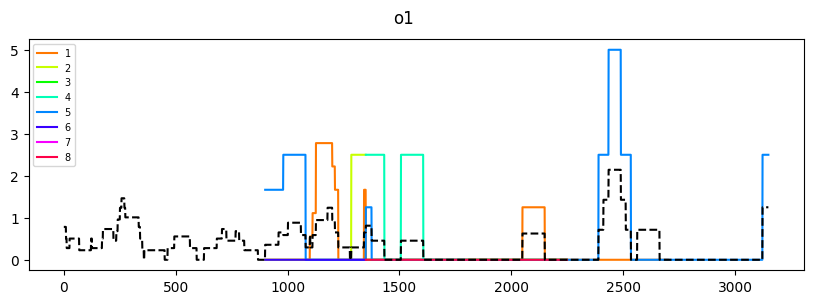

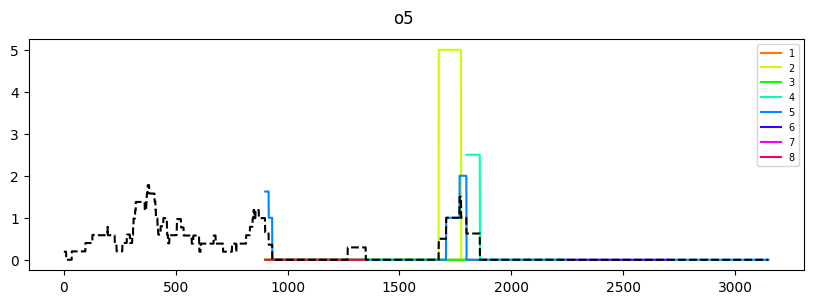

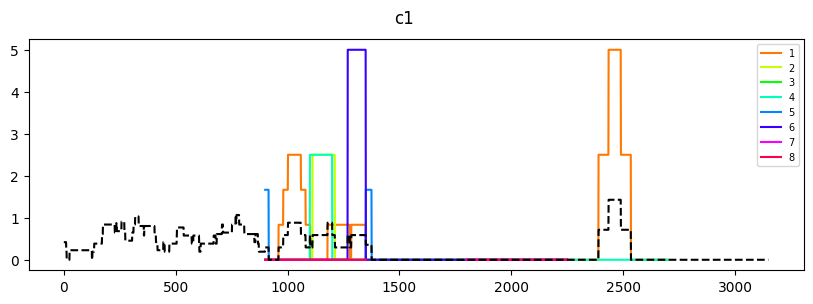

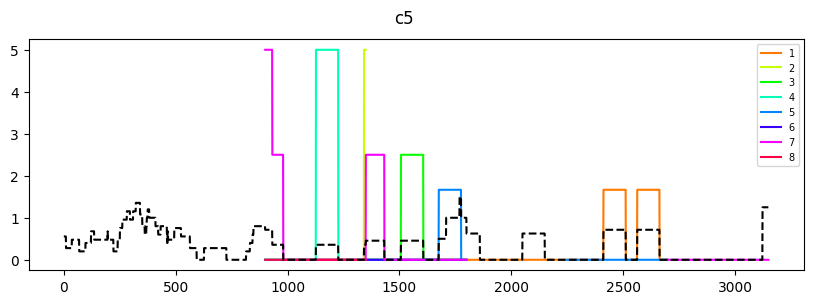

In [ ]:
palette = plt.get_cmap('hsv',64)
all_o1_tests = np.concatenate([o1_tests[0],o1_tests[1],o1_tests[2],o1_tests[3],o1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o1_avg_feature,'k--')
fig.suptitle('o1')
plt.legend( prop={'size': 7})

all_o5_tests = np.concatenate([o5_tests[0],o5_tests[1],o5_tests[2],o5_tests[3],o5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_o5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(o5_avg_feature,'k--')
fig.suptitle('o5')
plt.legend( prop={'size': 7})

all_c1_tests = np.concatenate([c1_tests[0],c1_tests[1],c1_tests[2],c1_tests[3],c1_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c1_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c1_avg_feature,'k--')
fig.suptitle('c1')
plt.legend( prop={'size': 7})

all_c5_tests = np.concatenate([c5_tests[0],c5_tests[1],c5_tests[2],c5_tests[3],c5_tests[4]],axis=1)
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(all_c5_tests):
    ax.plot(np.arange(o_i.shape[0])+900,o_i,label=stim_num[i],color=palette(i*8+5))
ax.plot(c5_avg_feature,'k--')
fig.suptitle('c5')
plt.legend( prop={'size': 7})

### Average trials by test feature

In [ ]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):

    task_sample = task_fr[task_fr['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    # use only the first 2 test stimuli presentations
    n_test = np.full(test_stimuli_samp.shape,np.nan)
    #n_test[:,:6] = test_stimuli_samp[:,:6]
    n_test = test_stimuli_samp
    n_test=n_test.astype(str)
    
    color_tests = get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient=color,stim_num=stim_num)
    orient_tests = get_sp_feature(sp_samples_samp,n_test,code_samples_samp,color_orient=orient,stim_num=stim_num)

    all_sample_feature[sample]["color"]= color_tests
    all_sample_feature[sample]["orientation"]= orient_tests

/tmp/ipykernel_139461/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


In [ ]:
o1_mean_sample = []
o5_mean_sample = []
c1_mean_sample = []
c5_mean_sample = []
for i in range(8):
    o1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o1_c5"]['orientation'][i].mean(axis=0)]))
    # print("o1 - o%d n trials: %d"%(i,o1[i].shape[0]))
    o5_mean_sample.append(np.array([all_sample_feature["o5_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o5_c5"]['orientation'][i].mean(axis=0)]))
    # print("o5 - o%d n trials: %d"%(i,o5[i].shape[0]))
    c1_mean_sample.append(np.array([all_sample_feature["o1_c1"]['color'][i].mean(axis=0),all_sample_feature["o5_c1"]['color'][i].mean(axis=0)]))
    # print("c1 - c%d n trials: %d"%(i,c1[i].shape[0]))
    c5_mean_sample.append(np.array([all_sample_feature["o1_c5"]['color'][i].mean(axis=0),all_sample_feature["o5_c5"]['color'][i].mean(axis=0)]))
    # print("c5 - c%d n trials: %d"%(i,c5[i].shape[0]))

/tmp/ipykernel_139461/2644372065.py:8: RuntimeWarning: Mean of empty slice.
  o5_mean_sample.append(np.array([all_sample_feature["o5_c1"]['orientation'][i].mean(axis=0),all_sample_feature["o5_c5"]['orientation'][i].mean(axis=0)]))


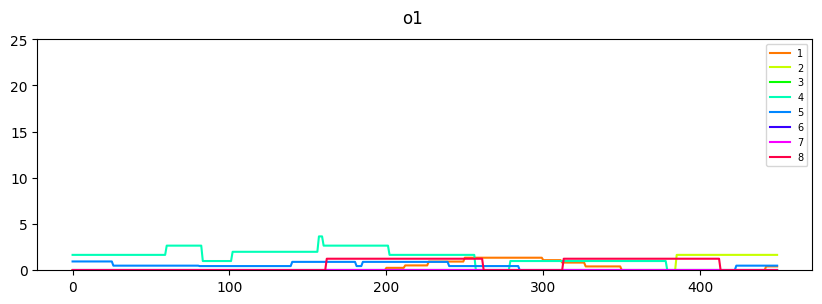

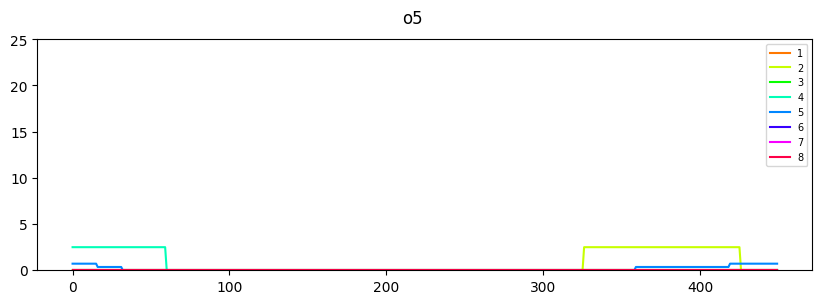

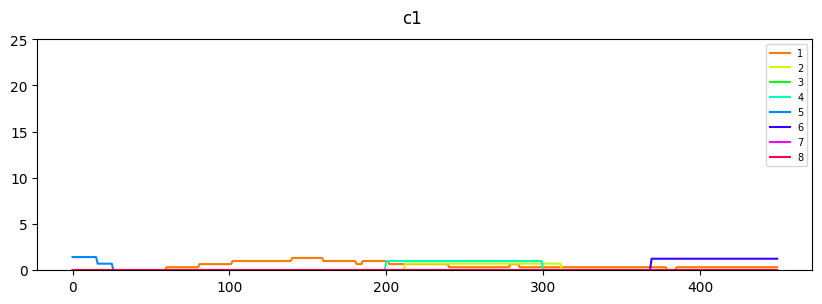

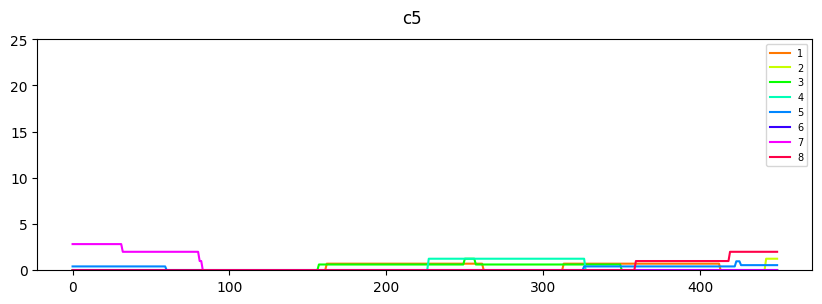

In [ ]:
palette = plt.get_cmap('hsv',64)

fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    ax.set_ylim(0,25)
    fig.suptitle('o1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(o5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    ax.set_ylim(0,25)
    fig.suptitle('o5')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c1_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    ax.set_ylim(0,25)
    fig.suptitle('c1')
    plt.legend( prop={'size': 7})
fig,ax = plt.subplots(figsize=(10,3))
for i, o_i in enumerate(c5_mean_sample):
    o_i = np.mean(o_i,axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d],label=stim_num[i],color=palette(i*8+5))
    ax.set_ylim(0,25)
    fig.suptitle('c5')
    plt.legend( prop={'size': 7})

### Avg activity by test feature

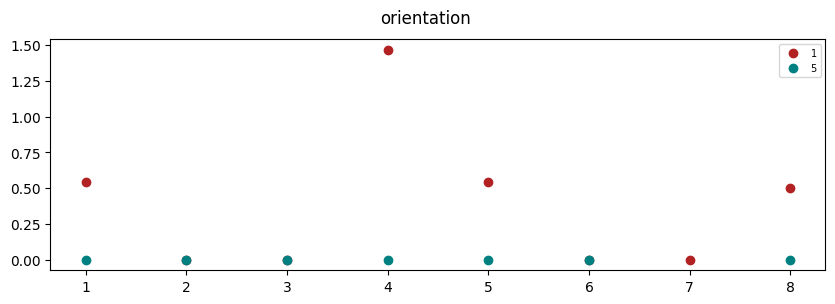

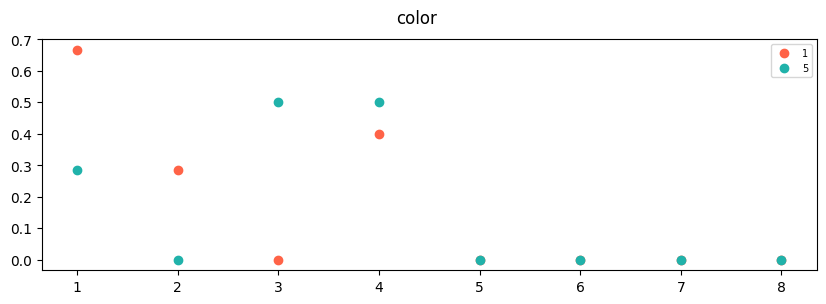

In [ ]:
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax = plt.subplots(figsize=(10,3))
o1_i_all=[]
o5_i_all=[]
for i, (o1_i,o5_i) in enumerate(zip(o1_mean_sample,o5_mean_sample)):
    o1_i_all.append(o1_i[:,100:350].mean()*1000)
    o5_i_all.append(o5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),o1_i_all,color=task_constants.PALETTE_B1[sample[0]],label='1')
ax.scatter(range(1,9),o5_i_all,color=task_constants.PALETTE_B1[sample[2]],label='5')
fig.suptitle('orientation')
ax.legend( prop={'size': 7})

fig,ax = plt.subplots(figsize=(10,3))
c1_i_all=[]
c5_i_all=[]
for i, (c1_i,c5_i) in enumerate(zip(c1_mean_sample,c5_mean_sample)):
    c1_i_all.append(c1_i[:,100:350].mean()*1000)
    c5_i_all.append(c5_i[:,100:350].mean()*1000)
    
ax.scatter(range(1,9),c1_i_all,color=task_constants.PALETTE_B1[sample[1]],label='1')
ax.scatter(range(1,9),c5_i_all,color=task_constants.PALETTE_B1[sample[3]],label='5')
fig.suptitle('color')
ax.legend( prop={'size': 7})

## Check if selective to color or orientation

In [ ]:
o1_all = []
o5_all = []
c1_all = []
c5_all = []
for i in range(8):
    o1_all.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
    print("o1 - o%d n trials: %d"%(i,o1_all[i].shape[0]))
    o5_all.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
    print("o5 - o%d n trials: %d"%(i,o5_all[i].shape[0]))
    c1_all.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
    print("c1 - c%d n trials: %d"%(i,c1_all[i].shape[0]))
    c5_all.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))
    print("c5 - c%d n trials: %d"%(i,c5_all[i].shape[0]))

o1 - o0 n trials: 31
o5 - o0 n trials: 18
c1 - c0 n trials: 28
c5 - c0 n trials: 14
o1 - o1 n trials: 8
o5 - o1 n trials: 4
c1 - c1 n trials: 10
c5 - c1 n trials: 6
o1 - o2 n trials: 12
o5 - o2 n trials: 7
c1 - c2 n trials: 6
c5 - c2 n trials: 9
o1 - o3 n trials: 8
o5 - o3 n trials: 6
c1 - c3 n trials: 8
c5 - c3 n trials: 7
o1 - o4 n trials: 21
o5 - o4 n trials: 28
c1 - c4 n trials: 14
c5 - c4 n trials: 21
o1 - o5 n trials: 6
o5 - o5 n trials: 4
c1 - c5 n trials: 10
c5 - c5 n trials: 5
o1 - o6 n trials: 3
o5 - o6 n trials: 6
c1 - c6 n trials: 8
c5 - c6 n trials: 11
o1 - o7 n trials: 8
o5 - o7 n trials: 5
c1 - c7 n trials: 10
c5 - c7 n trials: 8


In [ ]:
o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg=[],[],[],[]
n_trials=[]
for i in range(8):
    n_tr=[]
    avg = o1_all[i][:,100:350].mean(axis=1)*1000
    o1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = o5_all[i][:,100:350].mean(axis=1)*1000
    o5_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c1_all[i][:,100:350].mean(axis=1)*1000
    c1_trial_avg.append(avg)
    n_tr.append(len(avg))
    avg = c5_all[i][:,100:350].mean(axis=1)*1000
    c5_trial_avg.append(avg)
    n_tr.append(len(avg))
    n_trials.append(n_tr)

In [ ]:
n_trials

[[31, 18, 28, 14],
 [8, 4, 10, 6],
 [12, 7, 6, 9],
 [8, 6, 8, 7],
 [21, 28, 14, 21],
 [6, 4, 10, 5],
 [3, 6, 8, 11],
 [8, 5, 10, 8]]

### Plot

44.0

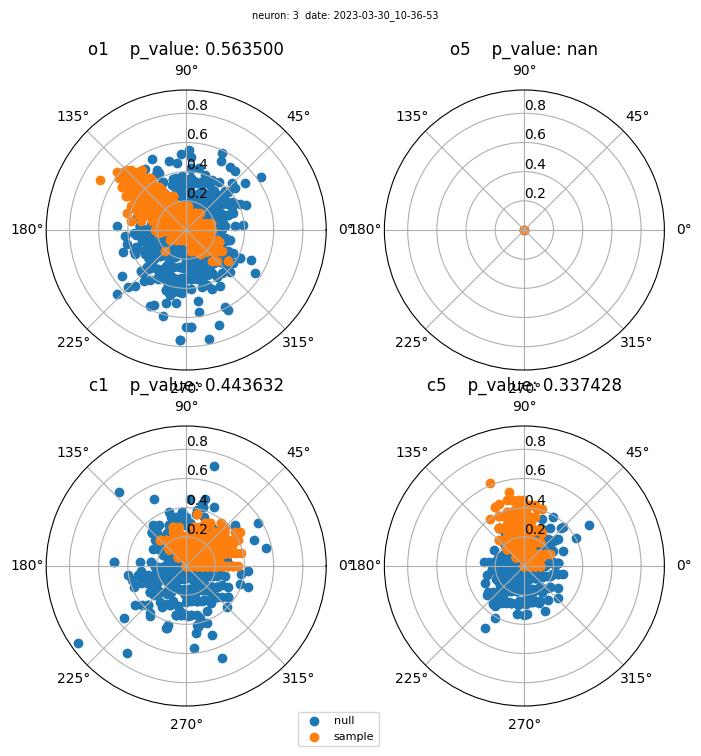

In [ ]:
selectivity_info: Dict[str, list] = defaultdict(list)

min_n_trials = np.min(n_trials,axis=1).astype(int)
all_select = []
all_null=[]
all_p_value=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):

    if np.sum(min_n_trials<3)>0 or np.concatenate(trial_avg).sum()==0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
    else:
        mean_select = select_rand_trials_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        mean_null = get_null_vector_from_samples(trial_avg,min_n_trials,seed,n_iterations=1000)
        p_value = permutation_test(mean_select,mean_null)

    all_select.append(mean_select)
    all_null.append(mean_null)
    all_p_value.append(p_value)
    selectivity_info['date'] += [date]
    selectivity_info['i_neuron'] += [i_neuron]
    selectivity_info['neuron_type'] += [data.clustersgroup[i_neuron]]
    selectivity_info['p_value'] += [p_value]
    selectivity_info['sample1'] += [feature]

selectivity_info = pd.DataFrame(selectivity_info) 

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax2,ax3,ax4],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    ax.scatter(all_null[i][:,1],all_null[i][:,0],label='null')
    ax.scatter(all_select[i][:,1],all_select[i][:,0],label='sample')
    ax.set_title('%s    p_value: %f'%(feature,all_p_value[i]) )
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

In [ ]:
pref_dir_o1_0 = np.abs(0-all_select[0][:,1]*180/np.pi) 
pref_dir_o5_0 = np.abs(0-all_select[1][:,1]*180/np.pi)
diff=[]
for i in range(len(pref_dir_o1_0)):
    shift = np.concatenate([pref_dir_o1_0[i:],pref_dir_o1_0[:i]])
    diff.append(shift-pref_dir_o5_0)
diff=np.concatenate(diff)
p_value_away_o = 1-np.sum(diff>0)/len(diff)
p_value_toward_o = 1-np.sum(diff<0)/len(diff)

pref_dir_c1_0 = np.abs(all_select[2][:,1]*180/np.pi - 0) 
pref_dir_c5_0 = np.abs(all_select[3][:,1]*180/np.pi - 0)
diff=[]
for i in range(len(pref_dir_o1_0)):
    shift = np.concatenate([pref_dir_c1_0[i:],pref_dir_c1_0[:i]])
    diff.append(shift-pref_dir_c5_0)
diff=np.concatenate(diff)
p_value_away_c = 1-np.sum(diff>0)/len(diff)
p_value_toward_c = 1-np.sum(diff<0)/len(diff)

In [ ]:
print(p_value_away_o)
print(p_value_away_c)

0.03600000000000003
0.761394


In [ ]:
print(np.mean(pref_dir_o1_0))
print(np.mean(pref_dir_o5_0))

160.59519646343193
0.0


/tmp/ipykernel_139461/3659575917.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
/tmp/ipykernel_139461/3659575917.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])


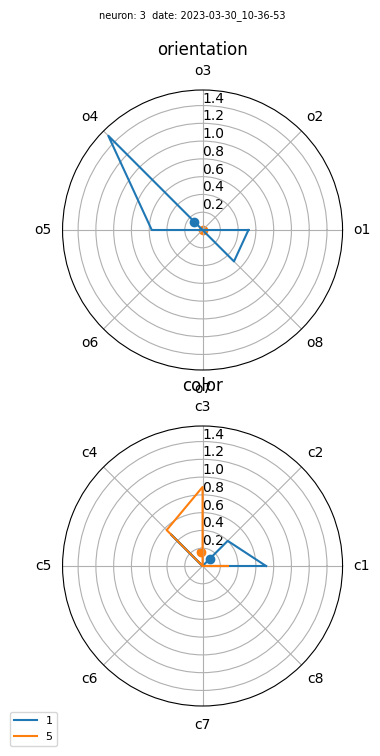

In [ ]:
stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
min_n_trials = np.min(n_trials,axis=1).astype(int)
dir_vector = []
all_mean_resp=[]
for trial_avg,feature in zip([o1_trial_avg,o5_trial_avg,c1_trial_avg,c5_trial_avg],['o1','o5','c1','c5']):
    if np.sum(min_n_trials<3)>0:
        p_value = np.nan
        mean_null = np.zeros((2,2))
        mean_select = np.zeros((2,2))
        mean_resp = np.zeros((8,3))
    else:
        mean_select=[]
        mean_resp = np.zeros((8,3))
        for i_num in range(8):
            fr = trial_avg[i_num]
            mean_resp[i_num] = [np.mean(fr),np.std(fr),stim_angle[i_num]]
    dir_vector.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,2]))
    all_mean_resp.append(mean_resp)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharey=True,subplot_kw={'projection': 'polar'})
for i,(ax, feature)in enumerate(zip([ax1,ax1,ax2,ax2],['o1','o5','c1','c5'])):
    ax.set_rlabel_position(90)
    mean_angle = np.concatenate([all_mean_resp[i][:,2],[all_mean_resp[i][0,2]]])
    mean_fr = np.concatenate([all_mean_resp[i][:,0],[all_mean_resp[i][0,0]]])
    ax.plot(mean_angle, mean_fr ,label=['1','5','1','5'][i])
    ax.scatter(dir_vector[i][1],dir_vector[i][0])
    title = 'color'
    
    if feature in ['o1','o5']:
        title = 'orientation'

    #ax.plot(all_mean_resp[i][:,2],all_mean_resp[i][:,0]+all_mean_resp[i][:,1],label='std')
    ax.set_title(title)
ax1.set_xticklabels(['o1','o2','o3','o4','o5','o6','o7','o8'])
ax2.set_xticklabels(['c1','c2','c3','c4','c5','c6','c7','c8'])    
fig.suptitle('neuron: %d  date: %s'%(i_neuron,date),fontsize=7)
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Testing